In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/home/annalena/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker:

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

In [3]:
envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

In [4]:
Phi_spheroid = plummer_potential


theta_spheroid = jnp.array([1e12, 10.0]) # (M, a) z.B. für Plummer

In [5]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law as df_spheroid
candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

Number of candidate actions: 250000


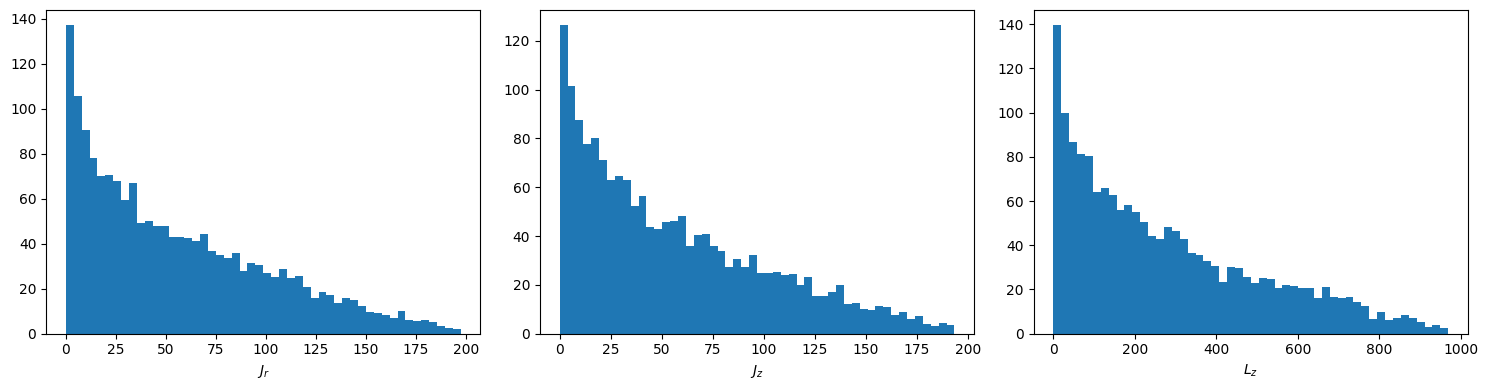

In [6]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

In [7]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)

Phase-space coordinates shape: (250000, 6)


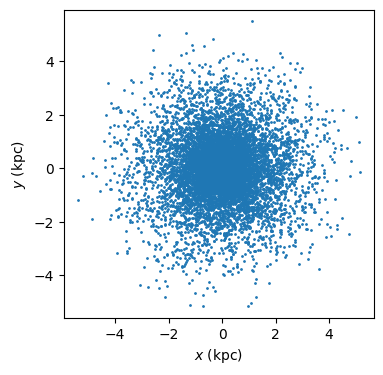

In [8]:
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

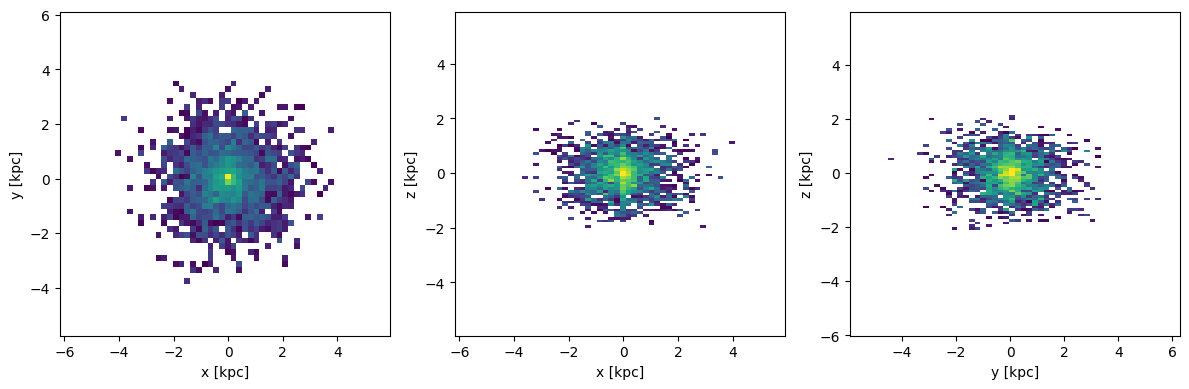

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

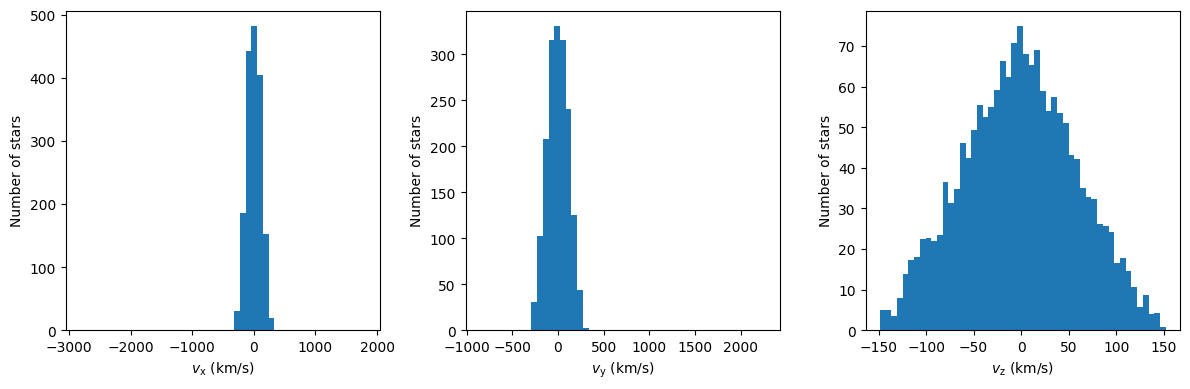

In [10]:
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

R = jnp.sqrt(x**2 + y**2)
mask = R > 0.0
v_x_masked = v_x[mask]
v_y_masked = v_y[mask]
v_z_masked = v_z[mask]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(v_x_masked, bins=50, weights=soft_weights[mask])#, range=(-500, 500))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")


plt.subplot(1,3,2)
plt.hist(v_y_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(1,3,3)
plt.hist(v_z_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

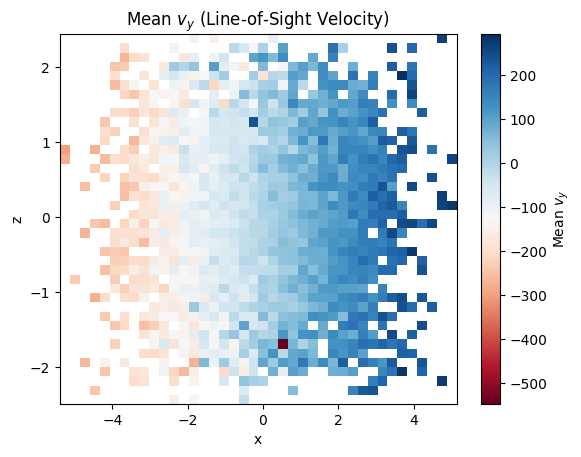

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y[mask], weights=soft_weights[mask])

# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu') #, vmin=-10000, vmax=10000)#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

In [12]:
import jax
import jax.numpy as jnp

def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2

    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid


In [13]:
r_bins = jnp.linspace(0.1, 100, 100) # Avoid 0 if potential has singularity at origin
z_bins = jnp.linspace(-50, 50, 100)

# JIT Compile
#jit_laplacian = jax.jit(compute_laplacian_on_grid)

# Run
#nabla2_Phi = jit_laplacian(r_bins, z_bins, theta)

nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_spheroid, r_bins, z_bins)

print("Laplacian shape:", nabla2_Phi.shape)

Laplacian shape: (99, 99)


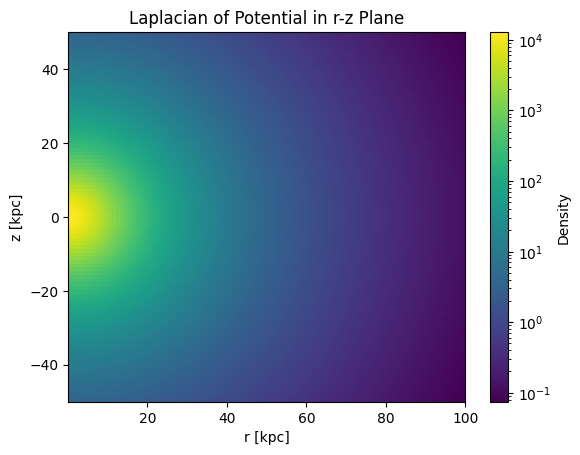

In [14]:
plt.imshow(nabla2_Phi.T, origin='lower', aspect='auto',
           extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Laplacian of Potential in r-z Plane')
plt.show()

In [15]:
import jax
import jax.numpy as jnp

def calculate_density_map_laxscan(x, y, z, soft_weights, r_bins, z_bins, bandwidth):
    # 1. Grid Setup
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')
    grid_coords = jnp.stack([R_grid, Z_grid], axis=-1)

    # 2. Particle Setup
    r_positions = jnp.sqrt(x**2 + y**2)
    positions_rz = jnp.stack([r_positions, z], axis=-1) # Shape: (N, 2)

    # 3. Constants
    total_mass = jnp.sum(soft_weights)
    normalization = 1.0 / (2 * jnp.pi * bandwidth**2)
    inv_two_bw_sq = 1.0 / (2 * bandwidth**2)

    # 4. Define the Scan Body
    def accumulation_step(carry_density_map, particle_data):
        """
        carry_density_map: The accumulated map (Grid_R, Grid_Z)
        particle_data: A tuple of (single_pos_rz, single_mass)
        """
        p_rz, p_mass = particle_data
        
        # Calculate squared distance for this specific particle to all grid points
        dist_sq = jnp.sum((grid_coords - p_rz)**2, axis=-1)

        #normalisation for calulation in cylindrical coordinates
        norm_coord_trafo = 1.0 / (2 * jnp.pi * jnp.maximum(grid_coords[..., 0], 1e-6) * bandwidth**2)
        
        # Calculate kernel contribution
        kernel = norm_coord_trafo * 1e12*(p_mass / total_mass) * normalization * jnp.exp(-dist_sq * inv_two_bw_sq)
        
        # Update the map (the carry)
        new_map = carry_density_map + kernel
        
        # Return (new_carry, output_at_this_step)
        # We don't need per-step output, so we return None for the second value
        return new_map, None

    # 5. Execute the Scan
    initial_map = jnp.zeros((len(r_centers), len(z_centers)))
    
    # scan takes: (function, initial_carry, (arrays_to_iterate_over))
    final_density_map, _ = jax.lax.scan(
        accumulation_step, 
        initial_map, 
        (positions_rz, soft_weights)
    )

    return final_density_map

In [16]:
density = calculate_density_map_laxscan(x, y, z, soft_weights, r_bins, z_bins, bandwidth=20)

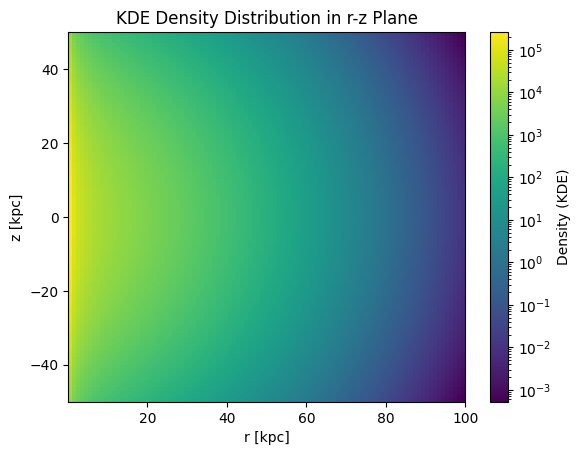

In [17]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density (KDE)')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('KDE Density Distribution in r-z Plane')
plt.show()

In [18]:
print(jnp.sum(nabla2_Phi))
print(jnp.mean(nabla2_Phi))
print(jnp.median(nabla2_Phi))

1.3041461e+06
133.06256
1.776104


In [19]:
#G=6.67e-11 
#G_kpc_Msun = G *(3.24e-20) * (1.99e30)
G=4.300917e-6 # in (km/s)^2 * kpc / Msun

value = 4*jnp.pi*G*density

print(jnp.sum(value))
print(jnp.mean(value))
print(jnp.median(value))
print(G)

1946.6616
0.19861867
0.0032191402
4.300917e-06


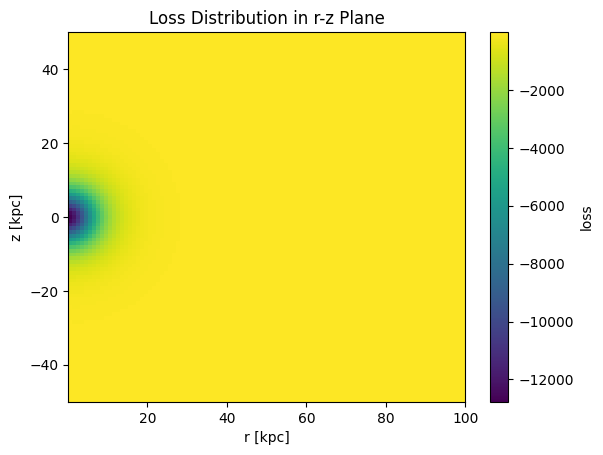

In [20]:
#G = 1e-11
#G=6.67e-11 
#G_kpc_Msun = G *(3.24e-20)**3 / (1.99e30)
#G_kpc_Msun = G *(3.24e-20)/ (1.99e30)

lossplane = (4*jnp.pi*G*density - nabla2_Phi)
#lossplane = (value - nabla2_Phi)
#lossplane = (4*jnp.pi*G_kpc_Msun*density - nabla2_Phi)
#mask = density > 0
#lossplane = lossplane * mask

plt.imshow(lossplane.T, origin='lower', aspect='auto',
           extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis')
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()

In [21]:
def loss_fn_complete(df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key_potential):

    candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key_potential, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key_potential, Phi_spheroid, theta_spheroid)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]

    nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_spheroid, r_bins, z_bins)

    # 1. Compute the KDE density
    density = calculate_density_map_laxscan(
        x, y, z, soft_weights, r_bins, z_bins, bandwidth=5.0
    )
    diff = (4*jnp.pi*G*density - nabla2_Phi)
    # 2. Define a scalar loss (e.g., Mean Squared Error or L2 loss)
    # The sum of squared differences is a common, differentiable loss.
    loss = jnp.sum((diff)**2)
    
    return loss

#loss_fn_complete = jax.jit(_loss_fn_complete_uncompiled, static_argnums=(0, 2))

In [22]:
# --- Gradient Calculation ---

# 1. Define the gradient function targeting theta_spheroid (index 3)
grad_theta_fn = jax.grad(loss_fn_complete, argnums=3)

# 2. Define the static key (required for jitter)
static_key = jax.random.PRNGKey(42)

# 3. Compute the gradient
# You need to pass all arguments, including the static key
theta_grad = grad_theta_fn(
    df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key
)

print(f"Gradient w.r.t. theta_spheroid: {theta_grad}")
print(f"Maximum gradient magnitude for theta_spheroid: {jnp.max(jnp.abs(theta_grad))}")

Gradient w.r.t. theta_spheroid: [ 1.1125180e-02 -2.1658678e+09]
Maximum gradient magnitude for theta_spheroid: 2165867776.0


In [23]:
# --- Gradient Calculation ---

# 1. Define the gradient function targeting theta_spheroid (index 1)
grad_param_fn = jax.grad(loss_fn_complete, argnums=1)

# 2. Define the static key (required for jitter)
static_key = jax.random.PRNGKey(42)

# 3. Compute the gradient
# You need to pass all arguments, including the static key
param_grad = grad_param_fn(
    df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key
)

print(f"Gradient w.r.t. params: {param_grad}")

Gradient w.r.t. params: {'Beta_spheroid': Array(-163.70644, dtype=float32, weak_type=True), 'Gamma_spheroid': Array(993.9081, dtype=float32, weak_type=True), 'J0_spheroid': Array(-0.12498123, dtype=float32, weak_type=True), 'N0_spheroid': Array(0.00045026, dtype=float32, weak_type=True), 'R0': Array(-2.829414e-07, dtype=float32, weak_type=True)}


In [24]:
def loss_fn_complete_adam(df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key_potential):
    
    #theta_rescaled = theta_spheroid
    # Rescale index 0: theta_rescaled = theta_rescaled.at[0].set(new_value)
    #theta_rescaled = theta_rescaled.at[0].set(theta_spheroid[0] * 1e12)
    # Rescale index 1: (Use the new array from the previous step)
    #theta_rescaled = theta_rescaled.at[1].set(theta_spheroid[1] * 1e4)
    #scaling_vector = jnp.array([1e12, 1e4]) 
    #theta_rescaled = theta_spheroid * scaling_vector

    candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key_potential, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key_potential, Phi_spheroid, theta_spheroid)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]

    nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_spheroid, r_bins, z_bins)

    # 1. Compute the KDE density
    density = calculate_density_map_laxscan(
        x, y, z, soft_weights, r_bins, z_bins, bandwidth=5.0
    )
    #diff = (4*jnp.pi*G_kpc_Msun*density - nabla2_Phi)
    diff = (4*jnp.pi*G*density - nabla2_Phi)
    
    # Gewichtung
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # Fokus auf Zentrum: r=0, z=0
    # Die Vorfaktoren (2 bei r) bestimmen, wie "schmal" der Fokus ist
    #weights = jnp.exp(-10 * R_grid**2) * jnp.exp(-Z_grid**2)
    #loss
    
    loss = jnp.sum((diff)**2)#*weights)
    
    return loss

In [25]:
import jax
import jax.numpy as jnp
import optax

def adam_optimizer(loss_fn_complete, df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key_potential, tol=1e-3, max_iter=1000):
    # Initialize optimizer
    optimizer = optax.adam(learning_rate=1e-1)
    #opt_state = optimizer.init(theta_spheroid)
    #log_theta = jnp.log(theta_spheroid)
    opt_state = optimizer.init(theta_spheroid)#log_theta)

    theta_history = []
    loss_history = []

    for iteration in range(max_iter):
        # Compute gradients
        #actual_theta = jnp.exp(log_theta)
        loss, grads  = jax.value_and_grad(lambda p: loss_fn_complete(df_spheroid, params, Phi_spheroid, p, n_candidates, envelope_max, r_bins, z_bins, key_potential))(theta_spheroid)
        loss_history.append(loss)
        theta_history.append(theta_spheroid)
        # Update parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        #log_theta = optax.apply_updates(log_theta, updates)
        theta_spheroid = optax.apply_updates(theta_spheroid, updates)

        if optax.global_norm(updates) < tol:
            print(f"Converged after {iteration} iterations.")
            break

    return theta_spheroid, jnp.array(theta_history), jnp.array(loss_history)

In [26]:
#theta_spheroid_init = jnp.array([1.0, 1.0])  # Initial guess for (M, a)
optimzed_theta, theta_hist, loss_hist = adam_optimizer(
    loss_fn_complete_adam, df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key,
    tol=1e-3, max_iter=100
)

In [27]:
print(loss_hist)

[4.9976218e+09 4.7866092e+09 4.5866348e+09 4.3972250e+09 4.2178982e+09
 4.0481905e+09 3.8876291e+09 3.7357683e+09 3.5921610e+09 3.4563786e+09
 3.3279959e+09 3.2066179e+09 3.0918469e+09 2.9833252e+09 2.8806881e+09
 2.7835924e+09 2.6917233e+09 2.6047718e+09 2.5224438e+09 2.4444690e+09
 2.3705848e+09 2.3005420e+09 2.2341153e+09 2.1710802e+09 2.1112365e+09
 2.0543921e+09 2.0003597e+09 1.9489774e+09 1.9000803e+09 1.8535204e+09
 1.8091583e+09 1.7668621e+09 1.7265100e+09 1.6879876e+09 1.6511843e+09
 1.6160019e+09 1.5823460e+09 1.5501284e+09 1.5192663e+09 1.4896814e+09
 1.4613029e+09 1.4340641e+09 1.4078995e+09 1.3827500e+09 1.3585601e+09
 1.3352801e+09 1.3128588e+09 1.2912543e+09 1.2704191e+09 1.2503151e+09
 1.2309051e+09 1.2121545e+09 1.1940285e+09 1.1764969e+09 1.1595313e+09
 1.1431030e+09 1.1271869e+09 1.1117581e+09 1.0967936e+09 1.0822742e+09
 1.0681773e+09 1.0544837e+09 1.0411779e+09 1.0282402e+09 1.0156577e+09
 1.0034124e+09 9.9149139e+08 9.7988134e+08 9.6856870e+08 9.5754227e+08
 9.467

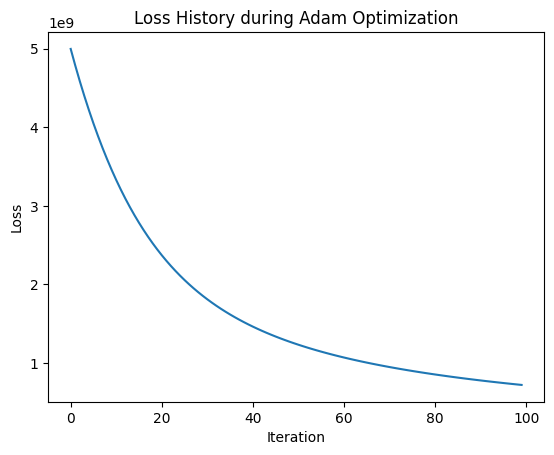

In [28]:
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History during Adam Optimization')
plt.show()

In [29]:
print(theta_hist[:,0])

[1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12
 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12 1.e+12]


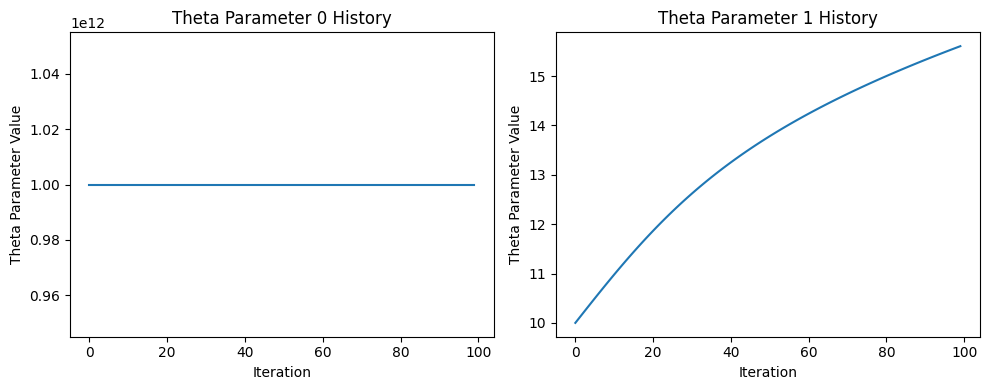

In [30]:
plt.figure(figsize=(10, 4))

# Plot for theta_hist[:, 0]
plt.subplot(1, 2, 1)
plt.plot(theta_hist[:, 0])
plt.xlabel('Iteration')
plt.ylabel('Theta Parameter Value')
plt.title('Theta Parameter 0 History')

# Plot for theta_hist[:, 1]
plt.subplot(1, 2, 2)
plt.plot(theta_hist[:, 1])
plt.xlabel('Iteration')
plt.ylabel('Theta Parameter Value')
plt.title('Theta Parameter 1 History')

plt.tight_layout()
plt.show()

In [31]:
print(theta_hist[-1,:])

[1.0000000e+12 1.5606228e+01]


In [32]:
def compute_optimitzed_density(df_spheroid, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, r_bins, z_bins, key_potential):
    scaling_vector = jnp.array([1e12, 1e4]) 
    theta_rescaled = theta_spheroid * scaling_vector

    candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key_potential, params, Phi_spheroid, theta_rescaled, n_candidates, envelope_max, tau=0.01)
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key_potential, Phi_spheroid, theta_rescaled)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]

    nabla2_Phi = compute_laplacian_on_grid(Phi_spheroid, theta_rescaled, r_bins, z_bins)

    # 1. Compute the KDE density
    kde_density = calculate_density_map_laxscan(
        x, y, z, soft_weights, r_bins, z_bins, bandwidth=5.0
    )
    diff = (4*jnp.pi*G*1e10 - nabla2_Phi)
    #diff = kde_density - (nabla2_Phi / (4 * jnp.pi * G))
    
    return diff, kde_density, nabla2_Phi, x, y, z

In [33]:
static_key = jax.random.PRNGKey(42)
final_diff, final_density_kde, final_nabla2_Phi, final_x, final_y, final_z = compute_optimitzed_density(
    df_spheroid, params, Phi_spheroid, theta_hist[-1,:], n_candidates, envelope_max, r_bins, z_bins, key
)

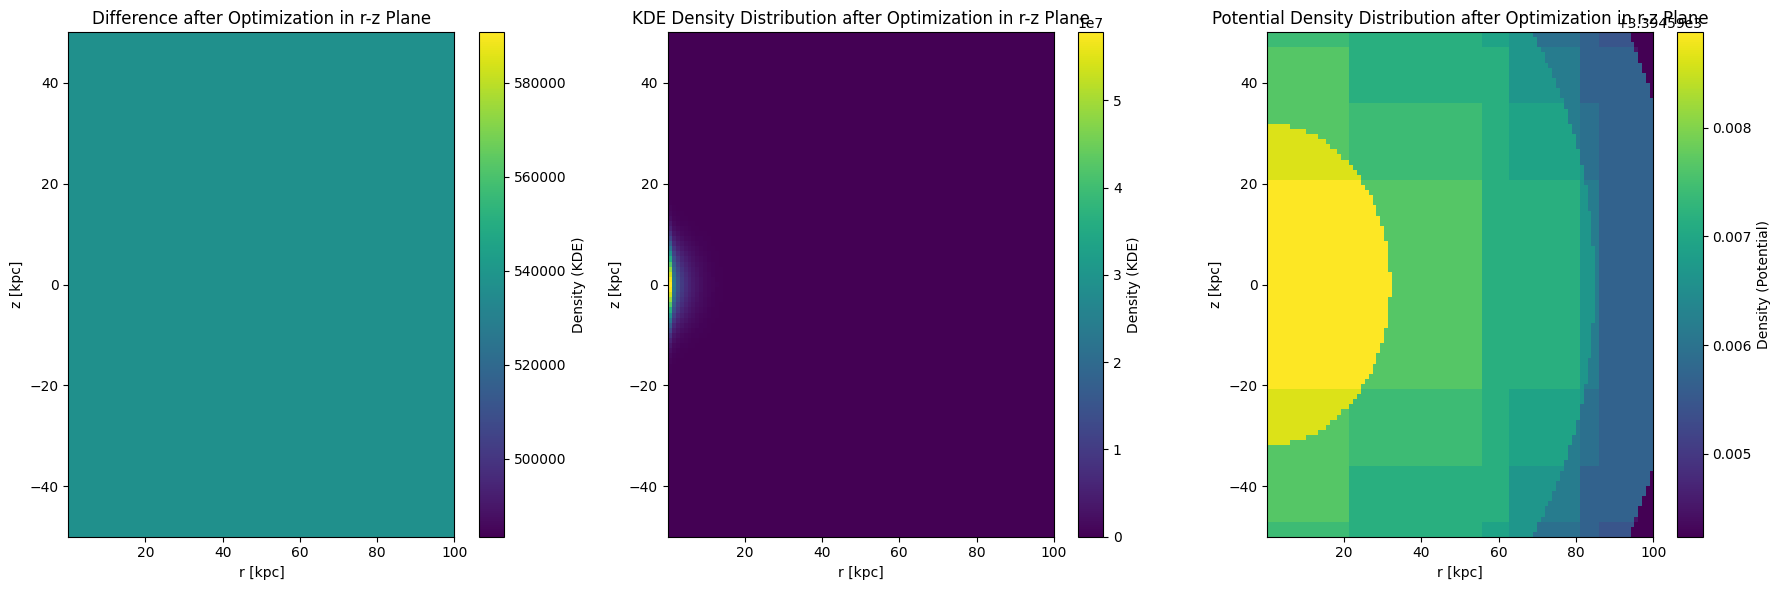

In [34]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Difference after Optimization
im1 = axs[0].imshow(final_diff.T, origin='lower', aspect='auto',
                     extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis')
fig.colorbar(im1, ax=axs[0], label='Density (KDE)')
axs[0].set_xlabel('r [kpc]')
axs[0].set_ylabel('z [kpc]')
axs[0].set_title('Difference after Optimization in r-z Plane')

# Plot 2: KDE Density Distribution after Optimization
im2 = axs[1].imshow(final_density_kde.T, origin='lower', aspect='auto',
                     extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis')
fig.colorbar(im2, ax=axs[1], label='Density (KDE)')
axs[1].set_xlabel('r [kpc]')
axs[1].set_ylabel('z [kpc]')
axs[1].set_title('KDE Density Distribution after Optimization in r-z Plane')

# Plot 3: Potential Density Distribution after Optimization
final_density_pot = final_nabla2_Phi
im3 = axs[2].imshow(final_density_pot.T, origin='lower', aspect='auto',
                     extent=[jnp.min(r_bins), jnp.max(r_bins), jnp.min(z_bins), jnp.max(z_bins)], cmap='viridis')
fig.colorbar(im3, ax=axs[2], label='Density (Potential)')
axs[2].set_xlabel('r [kpc]')
axs[2].set_ylabel('z [kpc]')
axs[2].set_title('Potential Density Distribution after Optimization in r-z Plane')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

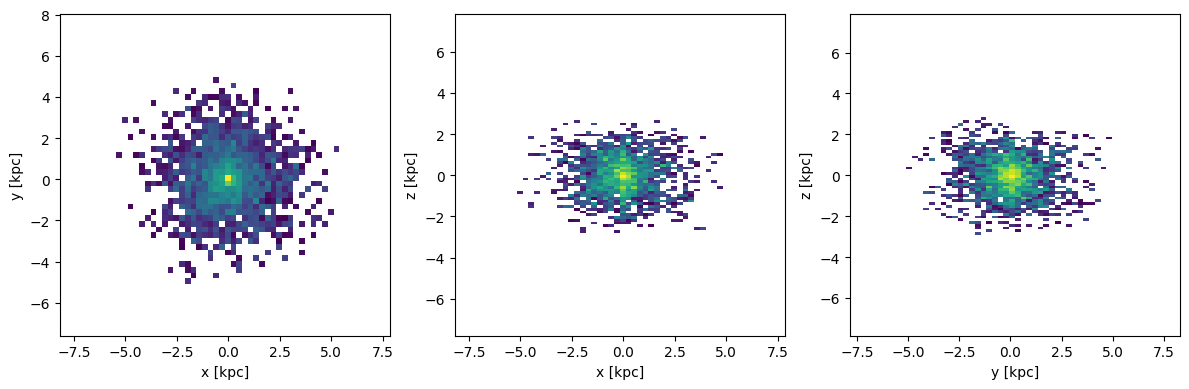

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(final_x, final_y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(final_x, final_z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(final_y, final_z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()